## Applying Transformers for time series classification with the Visual Transformer (ViT) approach

In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages not printed (for tensorflow mainly)
# sys.path.append('/home/roger/Documents/Multivariate_ts_transformer_predictor/')
# sys.path.append('/home/roger/Documents/Multivariate_ts_transformer_predictor/src')
sys.path.append(os.path.dirname(os.path.abspath('.')))
sys.path.append(os.path.dirname(os.path.abspath('./..')))

import numpy as np
import pandas as pd
from DataManager import DataManager
from YamlLoader import YamlLoader

---
## Loading the data

In [2]:
MAIN_PATH = os.path.dirname(os.path.realpath('./../'))
MAIN_PATH

'/Users/roger/Documents/UAB/4t_any/TFG/Multivariate_ts_transformer_predictor'

In [3]:
yl = YamlLoader()
conf = yl.load_yaml(path=MAIN_PATH + '/src/config/data_config.yaml')

In [4]:
conf

{'create_npys': False,
 'targets': ['preemptive', 'reactive', 'training'],
 'shuffle': False,
 'test_split': 0.2,
 'val_split': 0.2,
 'dirs': {'preemptive': '/data/Twist-Preemptive-Verification/',
  'reactive': '/data/Twist-Reactive-Verification/',
  'training': '/data/Twist-Training/',
  'modified_csvs': '/data/Modified_csvs/',
  'npys': '/data/Npy_files/'}}

In [5]:
dm = DataManager(main_path=MAIN_PATH, config=conf)

In [6]:
data_dict = dm.run_pipeline()
print(f'Preemptive: {data_dict["preemptive"]["pad_data"].shape}')
print(f'Reactive: {data_dict["reactive"]["pad_data"].shape}')
print(f'Training: {data_dict["training"]["pad_data"].shape}')

Running pipeline for target preemptive...
-> Loading files to np array
-> Applying transforms
Running pipeline for target reactive...
-> Loading files to np array
-> Applying transforms
Running pipeline for target training...
-> Loading files to np array
-> Applying transforms
DONE
DONE
DONE
Preemptive: (330, 9, 3585)
Reactive: (241, 9, 3585)
Training: (250, 9, 3585)


In [ ]:
(x_train, y_train), (x_test, y_test) = dm.load_train_test_data(data_dict=data_dict)
with open('x_train.npy', 'wb') as f:
    np.save(f, x_train)

with open('y_train.npy', 'wb') as f:
    np.save(f, y_train)

with open('x_test.npy', 'wb') as f:
    np.save(f, x_test)

with open('y_test.npy', 'wb') as f:
    np.save(f, y_test)

x_train, x_val, y_train, y_val = dm.load_train_val_data(x=x_train, y=y_train, shuffle=True)

In [ ]:
x_train.shape[1:]

---
## Visual Transformer model

From: https://towardsdatascience.com/understand-and-implement-vision-transformer-with-tensorflow-2-0-f5435769093

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
training_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
autotune = tf.data.experimental.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)

In [ ]:
# Generating pathces (image sections)
class GeneratePatch(layers.Layer):
    def __init__(self, patch_size: int = 16):
        super(GeneratePatch, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        print(f'Images shape = {tf.shape(images)}')
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], 
            strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
from itertools import islice, count
import matplotlib.pyplot as plt

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy() 


patch_size = 16
generate_patch_layer = GeneratePatch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)



def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel([np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

        


render_image_and_patches(train_iter_7im, patches)

---
## Brute forcing the data into basic Transformer

Model from: https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [14]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [8]:
# x_train = np.load('x_train.npy')
# y_train = np.load('y_train.npy')
# x_test = np.load('x_test.npy')
# y_test = np.load('y_test.npy')
(x_train, y_train), (x_test, y_test) = dm.load_train_test_data(data_dict=data_dict)

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [10]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=2
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


In [11]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

eval = model.evaluate(x_test, y_test, verbose=1)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 3585)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 3585)     7170        ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 3585)     14690817    ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
             

In [12]:
loss = history.history['loss']
acc = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_sparse_categorical_accuracy']

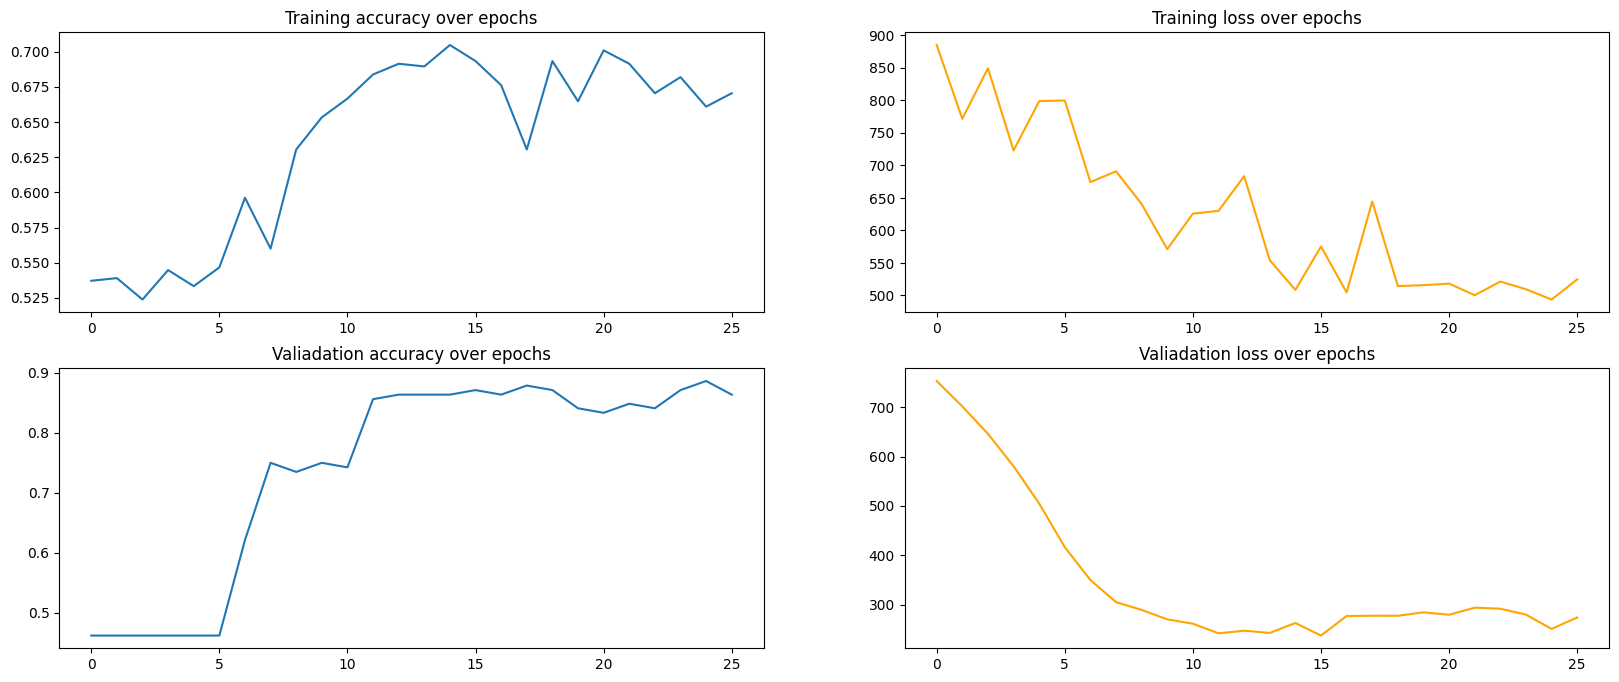

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes[0, 0].plot(acc, label='Training accuracy')
axes[0, 0].title.set_text('Training accuracy over epochs')
axes[0, 1].plot(np.array(loss), label='Training loss', color='orange')
axes[0, 1].title.set_text('Training loss over epochs')



axes[1, 0].plot(val_acc, label='Validation accuracy')
axes[1, 0].title.set_text('Valiadation accuracy over epochs')
axes[1, 1].plot(np.array(val_loss), label='Validation loss', color='orange')
axes[1, 1].title.set_text('Valiadation loss over epochs')


plt.show()

In [16]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
)
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]

history = model.fit(
    x_train,
    tf.one_hot(y_train, 2),
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
)

eval = model.evaluate(x_test, tf.one_hot(y_test, 2), verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 3585)]    0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 6, 3585)     7170        ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 6, 3585)     14690817    ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

In [17]:
loss = history.history['loss']
acc = history.history['binary_accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_binary_accuracy']

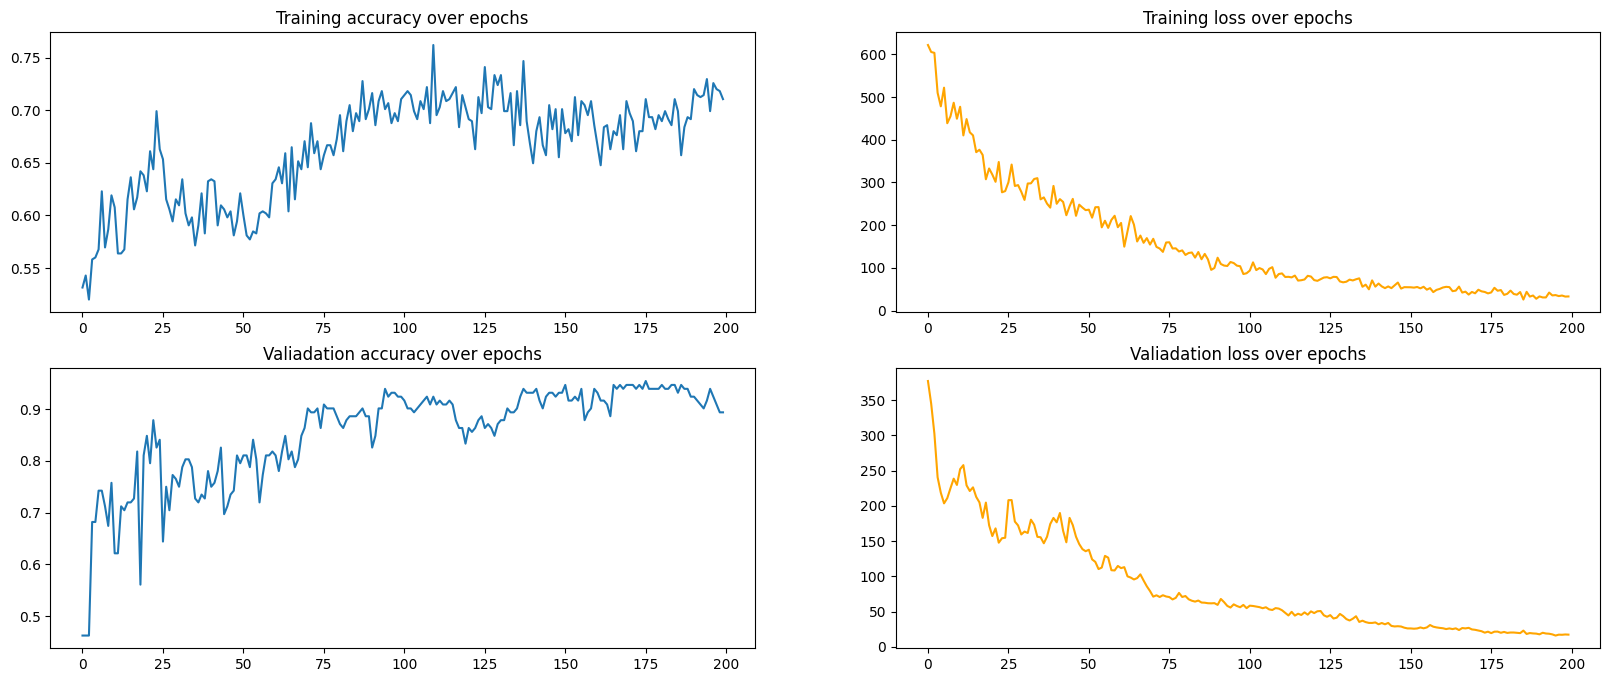

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes[0, 0].plot(acc, label='Training accuracy')
axes[0, 0].title.set_text('Training accuracy over epochs')
axes[0, 1].plot(np.array(loss), label='Training loss', color='orange')
axes[0, 1].title.set_text('Training loss over epochs')



axes[1, 0].plot(val_acc, label='Validation accuracy')
axes[1, 0].title.set_text('Valiadation accuracy over epochs')
axes[1, 1].plot(np.array(val_loss), label='Validation loss', color='orange')
axes[1, 1].title.set_text('Valiadation loss over epochs')


plt.show()